In [27]:
!pip install osmnx

In [28]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [29]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [30]:
# ====================================
# 1. OBTER O GRAFO DA CIDADE DE NATAL
# ====================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [31]:
# ==============================================
# 2. OBTER PONTOS DE INTERESSE (PONTOS DE TÁXI)
# ==============================================
tags = {'amenity': 'taxi'}
pois = ox.features.features_from_place(place, tags=tags)

taxi_points = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        taxi_points.append((row.geometry.y, row.geometry.x))
    else:
        taxi_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

# Se não houver pontos de táxi, podemos usar uma alternativa para fins de teste
if not taxi_points:
    print("Nenhum ponto de táxi encontrado. Usando pontos alternativos (ex: bancos).")
    tags = {'amenity': 'bank'}
    pois = ox.features.features_from_place(place, tags=tags)
    for idx, row in pois.iterrows():
        if row.geometry.geom_type == 'Point':
            taxi_points.append((row.geometry.y, row.geometry.x))
        else:
            taxi_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
    if not taxi_points:
        raise ValueError("Nenhum POI encontrado.")

In [32]:
# =======================================================
# 3. ENCONTRAR NÓS MAIS PRÓXIMOS DOS PONTOS DE INTERESSE
# =======================================================
latitudes = [tp[0] for tp in taxi_points]
longitudes = [tp[1] for tp in taxi_points]
taxi_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
taxi_nodes = list(set(taxi_nodes))

if len(taxi_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

In [33]:
len(taxi_points)

19

In [34]:
# ========================================================================
# 4. CONSTRUIR GRAFO COMPLETO COM MENRO ROTA ENTRE OS PONTOS DE INTERESSE
# ========================================================================
G_interest = nx.Graph()
for i in range(len(taxi_nodes)):
    for j in range(i+1, len(taxi_nodes)):
        route = nx.shortest_path(G_undirected, taxi_nodes[i], taxi_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']
        G_interest.add_edge(taxi_nodes[i], taxi_nodes[j], weight=route_length)

In [35]:
# ==================
# 5. CALCULAR O MST
# ==================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os pontos de táxi:", total_mst_length, "metros")

mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

Comprimento total do MST entre os pontos de táxi: 34088.04723208844 metros


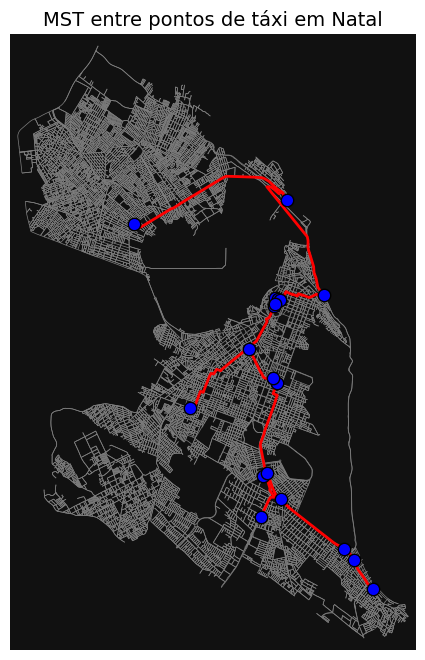

In [36]:
# ================================
# 6. APRESENTAR O RESULTADO FINAL
# ================================
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Desenhar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Desenhar os pontos de táxi em azul
poi_x = [G_undirected.nodes[n]['x'] for n in taxi_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in taxi_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black')

plt.title("MST entre pontos de táxi em Natal", fontsize=14)
plt.show()